In [5]:
#!pip install daft
#!pip install jupyterstan
#!pip install pandas
#!pip install sklearn
#!pip install scipy
#!pip install Pillow

In [ ]:
%load_ext jupyterstan
import matplotlib.pyplot as plt
import numpy as np
plt.ion()

## 1.1. Coin flip

In [24]:
%%stan coin_flip
data {
    int N;
    int x[N];
}
parameters {
    real<lower=0, upper=1> theta;
}
model {
    x ~ bernoulli(theta);
}


INFO:pystan:COMPILING THE C++ CODE FOR MODEL coin_flip_8ac56cb9cf265621492bb404a952ac28 NOW.


Creating pystan model & assigning it to variable name "coin_flip".
Stan options:
 {'model_name': 'coin_flip', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "coin_flip"!
Compilation took 42 seconds.


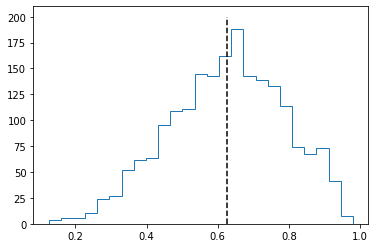

In [25]:
fit = coin_flip.sampling(
    data={'x': [1, 0, 0, 1, 1, 1], 'N': 6},
    iter=1000,
    chains=4
)

theta_samples = fit.extract()["theta"]
plt.hist(theta_samples, 25, histtype='step')
plt.vlines(np.mean(theta_samples), 0, 200, linestyle="--", label="estimated $theta$ (unknown)")


## 1.2: 20 questions

In [50]:
%%stan twenty_questions
#Twenty Questionn, code form the book baysian cognitive models
data { 
  int<lower=0> np;  // rows
  int<lower=0> nq;  // columns
  int k[np,nq];
  int k_na[np,nq];  // locating NAs in k
  int n_na;         // number of NAs
}
parameters {
  real<lower=0,upper=1> p[np];
  real<lower=0,upper=1> q[nq];
} 
transformed parameters {
  real<lower=0,upper=1> theta[np,nq];
  // Probability Correct Is Product Of Question By Person Rates
  for (i in 1:np)
    for (j in 1:nq)
      theta[i,j] <- p[i] * q[j];
  
}
model {
  // Priors For People and Questions
  p ~ beta(1, 1);
  q ~ beta(1, 1);
    
  // Correctness Of Each Answer Is Bernoulli Trial
  for (i in 1:np)
    for (j in 1:nq)
      if (k_na[i,j] == 0)     // If k[i,j] is not missing
        k[i,j] ~ bernoulli(theta[i,j]);
}
generated quantities {
  int na_array[n_na];p
  int index;
  
  index <- 1;
  for (i in 1:np) {
    for (j in 1:nq) {   
      if (k_na[i,j] == 1) {   // If k[i,j] is missing
        na_array[index] <- bernoulli_rng(theta[i,j]);
        index <- index + 1;
      }
    }
  }
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL twenty_questions_d7118d9d3f48b871d5f2fe272bab0b6e NOW.


Creating pystan model & assigning it to variable name "twenty_questions".
Stan options:
 {'model_name': 'twenty_questions', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "twenty_questions"!
Compilation took 42 seconds.


In [82]:
data = np.array([[1,1,1,1,0,0,1,1,0,1,0,0,np.nan,0,0,1,0,1,0,0],
        [0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0],
        [1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,0,1,0,0],
        [1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0],
        [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
        [0,0,0,0,np.nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
        [0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1],
        [1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,np.nan,0,0]])

In [83]:
np_, nq_ = data.shape
k_na = np.zeros_like(data).astype(np.int)
na_indeces = np.argwhere(np.isnan(data))
na_x = na_indeces[:, 0]
na_y = na_indeces[:, 1]
k_na[na_x, na_y] = 1
n_na = len(na_x)

data[np.isnan(data)] = 0
data = data.astype(np.int)



In [84]:
fit = twenty_questions.vb(
    data={'np': np_, 'nq': nq_, 'k': data, 'k_na': k_na, 'n_na':n_na}, iter=10e5
)
fit = pystan_vb_extract(fit)

/anaconda3/envs/stan/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


In [90]:
p = np.mean(fit['p'], axis=0)
q = np.mean(fit['q'], axis=0)
p, q

(array([0.89624331, 0.30372052, 0.4712038 , 0.3465624 , 0.86185336,
        0.84876026, 0.23857402, 0.0840287 , 0.7057258 , 0.51734442]),
 array([0.74794701, 0.69871719, 0.73968346, 0.66574776, 0.13796357,
        0.25032629, 0.74667629, 0.84045217, 0.29177803, 0.84113753,
        0.1514244 , 0.43770691, 0.80970098, 0.14995989, 0.13932807,
        0.51495225, 0.14746654, 0.81044483, 0.15512391, 0.32404641]))

In [95]:
fit['na_array'].mean(axis=0)

array([0.731, 0.012, 0.399])

In [96]:
#dose the reslts make sense, find out in the data  
data

array([[1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

# 2. Understanding Mahchine learning algorithms

### 2.1. Simple linear regression


In [359]:
%%stan simple_linear_regression
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
}

Creating pystan model & assigning it to variable name "linear_regression".
Stan options:
 {'model_name': 'linear_regression', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}


INFO:pystan:COMPILING THE C++ CODE FOR MODEL linear_regression_8e0f87fef8056f4b19a98f5e63de0fa1 NOW.


StanModel now available as variable "linear_regression"!
Compilation took 44 seconds.


In [360]:
n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)

fit = simple_linear_regression.sampling(
    data={'x': x, 'y': y, 'N': 11},
    iter=1000,
    chains=4
).extract()


OrderedDict([('alpha',
              array([1.59300377, 2.45156784, 1.37840045, ..., 1.32268904, 0.85755392,
                     1.65259188])),
             ('beta',
              array([6.60790461, 5.06659571, 5.77083418, ..., 7.0557764 , 7.98124639,
                     6.71047637])),
             ('sigma',
              array([1.01328737, 0.98842455, 1.15053097, ..., 0.87900454, 1.35537137,
                     0.64840771])),
             ('lp__',
              array([-4.15950169, -5.96235059, -6.13896881, ..., -4.02173944,
                     -5.65973695, -5.89225016]))])

In [364]:
#point estimat
alpha = fit['alpha'].mean(axis=0)
beta = fit['beta'].mean(axis=0)
alpha, beta
#plot the line, the credible interval

(1.4545435670063511, 6.713487553648372)

### 2.2. Linear regression

In [65]:
from collections import OrderedDict
def pystan_vb_extract(results):
    param_specs = results['sampler_param_names']
    samples = results['sampler_params']
    n = len(samples[0])

    # first pass, calculate the shape
    param_shapes = OrderedDict()
    for param_spec in param_specs:
        splt = param_spec.split('[')
        name = splt[0]
        if len(splt) > 1:
            idxs = [int(i) for i in splt[1][:-1].split(',')]  # no +1 for shape calculation because pystan already returns 1-based indexes for vb!
        else:
            idxs = ()
        param_shapes[name] = np.maximum(idxs, param_shapes.get(name, idxs))

    # create arrays
    params = OrderedDict([(name, np.nan * np.empty((n, ) + tuple(shape))) for name, shape in param_shapes.items()])

    # second pass, set arrays
    for param_spec, param_samples in zip(param_specs, samples):
        splt = param_spec.split('[')
        name = splt[0]
        if len(splt) > 1:
            idxs = [int(i) - 1 for i in splt[1][:-1].split(',')]  # -1 because pystan returns 1-based indexes for vb!
        else:
            idxs = ()
        params[name][(..., ) + tuple(idxs)] = param_samples

    return params

In [3]:
%%stan linear_regression
data {
    int<lower=0> N;
    int<lower=0> D;
    matrix[N,D] X;
    vector[N] y;
}
parameters {
    vector[D] w;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(X*w + beta, sigma);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL linear_regression_ac4d39ecd90533d9962124a59c7c2886 NOW.


Creating pystan model & assigning it to variable name "linear_regression".
Stan options:
 {'model_name': 'linear_regression', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "linear_regression"!
Compilation took 45 seconds.


In [4]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
N = len(X_train)
D = len(X_train[0])

In [19]:
fit = linear_regression.optimizing(
    data={'N': N, 'D': D, 'X': X_train, 'y': y_train}, init='random'
)


In [20]:
w = fit['w']
beta = fit['beta']

In [53]:
from sklearn.metrics import mean_squared_error

y_pred = np.dot(X_test, w) + beta
mean_squared_error(y_pred, y_test)

22.994162467655553

In [77]:
fit = linear_regression.vb(
    data={'N': N, 'D': D, 'X': X_train, 'y': y_train}, iter=10e5
)
fit = pystan_vb_extract(fit)

In [78]:
w = fit['w'].mean(axis=0)
beta = fit['beta'].mean(axis=0)
w, beta

(array([-1.18860198e-01,  6.21102261e-02, -4.65102206e-03,  2.91529681e+00,
        -1.81205662e+01,  3.62492359e+00,  5.90720006e-03, -1.46998990e+00,
         3.32158736e-01, -1.29446081e-02, -9.80761122e-01,  7.69009653e-03,
        -4.77222160e-01]), 38.58793947032195)

In [79]:
y_pred = np.dot(X_test, w) + beta
mean_squared_error(y_pred, y_test)

22.171224680402997

In [57]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_squared_error(y_pred, y_test)

21.817976737052096

### 2.3 Bayesian Linear regression

In [58]:
%%stan bayesian_linear_regression
data {
    int<lower=0> N;
    int<lower=0> D;
    matrix[N,D] X;
    vector[N] y;
}
parameters {
    vector[D] w;
    real beta;
    real sigma_squar;
    real<lower=0> tau;
}
transformed parameters {
    real<lower=0> t_tau;
    t_tau =  inv(tau);
}
model {
    tau ~ gamma(1,1);
    sigma_squar ~ inv_gamma(1,1);
    w ~ normal(0, t_tau);
    y ~ normal(X*w + beta, sigma_squar);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL bayesian_linear_regression_025cfd999e42fea71c66c43453cf32b3 NOW.


Creating pystan model & assigning it to variable name "bayesian_linear_regression".
Stan options:
 {'model_name': 'bayesian_linear_regression', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "bayesian_linear_regression"!
Compilation took 44 seconds.


In [74]:
fit = bayesian_linear_regression.vb(
    data={'N': N, 'D': D, 'X': X_train, 'y': y_train}, iter=10e4
)
fit = pystan_vb_extract(fit)

In [75]:
w = fit['w'].mean(axis=0)
beta = fit['beta'].mean(axis=0)
w, beta

(array([-0.11602466,  0.05842148, -0.04322857,  1.79147079, -0.49222133,
         4.72463426, -0.00584015, -1.0401059 ,  0.2232276 , -0.01273273,
        -0.53334438,  0.01043178, -0.43747648]), 11.707233878572886)

In [76]:
y_pred = np.dot(X_test, w) + beta
mean_squared_error(y_pred, y_test)

22.33689198227719

### 2.4 Bayesian Linear regression with ARD


In [100]:
%%stan bayesian_linear_regression_ard
data {
    int<lower=0> N;
    int<lower=0> D;
    matrix[N,D] X;
    vector[N] y;
}
parameters {
    vector[D] w;
    real beta;
    real sigma_squar;
    vector<lower=0>[D] alpha;
}
transformed parameters {  
    vector<lower=0>[D] t_alpha;
    for (d in 1:D) 
      t_alpha[d] = 1/sqrt(alpha[d]);

}
model {
    sigma_squar ~ inv_gamma(1, 1);
    alpha ~ gamma(1e-3, 1e-3);
    w ~ normal(0, t_alpha);
    y ~ normal(X*w + beta, sigma_squar);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL bayesian_linear_regression_ard_c20a2a4c04ea611c1c0e74b2b49e461a NOW.


Creating pystan model & assigning it to variable name "bayesian_linear_regression_ard".
Stan options:
 {'model_name': 'bayesian_linear_regression_ard', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "bayesian_linear_regression_ard"!
Compilation took 52 seconds.


In [195]:
noise = np.random.random((len(X_train), 13)) * 1000
fit = bayesian_linear_regression_ard.vb(
    data={'N': N, 'D': D + 13, 'X': np.hstack([X_train, noise]), 'y': y_train}, iter=10e5
)
fit = pystan_vb_extract(fit)

In [198]:
w = fit['w'].mean(axis=0)
beta = fit['beta'].mean(axis=0)
w, beta, np.linalg.norm(w)

(array([-6.90121257e-02,  4.74786329e-02, -8.42614329e-03,  1.87504653e+00,
        -4.45859488e-03,  4.15352489e+00, -1.35787745e-02, -1.01710407e+00,
         1.42945142e-01, -1.09657831e-02, -7.57784942e-01,  7.92614755e-03,
        -4.82479737e-01, -2.08220102e-04,  1.72467094e-03, -4.51219736e-04,
        -4.00223803e-04, -1.23885124e-03,  1.35443226e-03,  1.30568824e-03,
        -6.05107099e-04,  4.79955686e-04, -1.20838991e-03,  1.37960120e-03,
         1.08466355e-03, -5.35710944e-04]),
 19.34023524018347,
 4.757837353841128)

In [199]:
noise = np.random.random((len(X_test), 13)) * 1000
y_pred = np.dot(np.hstack([X_test, noise]), w) + beta
mean_squared_error(y_pred, y_test)

21.909086498825797

In [203]:
noise = np.random.random((len(X_train), 13)) * 1000
fit = linear_regression.vb(
    data={'N': N, 'D': D + 13, 'X': np.hstack([X_train, noise]), 'y': y_train}, iter=10e5
)
fit = pystan_vb_extract(fit)
w = fit['w'].mean(axis=0)
beta = fit['beta'].mean(axis=0)
noise = np.random.random((len(X_test), 13)) * 1000
y_pred = np.dot(np.hstack([X_test, noise]), w) + beta
mean_squared_error(y_pred, y_test)

22.34880219784789

In [204]:
np.linalg.norm(w)

8.587774881556886

### 2.5 Logistic regression

In [226]:
%%stan bayesian_logistic_regression_ard
data {
    int<lower=0> N;
    int<lower=0> D;
    matrix[N,D] X;
    int<lower=0,upper=1> y[N];
}
parameters {
    vector[D] w;
    vector<lower=0>[D] alpha;
}
transformed parameters {
    vector<lower=0>[D] t_alpha;
    for (d in 1:D) t_alpha[d] = 1/sqrt(alpha[d]);
}
model {
    alpha ~ gamma(1,1);
    w ~ normal(0, t_alpha);
    //same as bernoulli(inv_logit(alpha + beta * x[n]))
    y ~ bernoulli_logit(X*w);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL bayesian_logistic_regression_ard_46c29c163d492dc987ecf39feab6dcdb NOW.


Creating pystan model & assigning it to variable name "bayesian_logistic_regression_ard".
Stan options:
 {'model_name': 'bayesian_logistic_regression_ard', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "bayesian_logistic_regression_ard"!
Compilation took 41 seconds.


In [228]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data['data']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
N = len(X_train)
D = len(X_train[0])

In [229]:
fit = bayesian_logistic_regression_ard.vb(
    data  = {'N': N, 'D': D, 'X': X_train, 'y': y_train}
)
fit = pystan_vb_extract(fit)
w = fit['w'].mean(axis=0)


In [236]:
from sklearn.metrics import accuracy_score
pred = 1 / (1 + np.exp(-np.dot(X_test, w)))
accuracy_score(pred>0.5, y_test)

In [240]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(pred, y_test)

/anaconda3/envs/stan/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9181286549707602

#### 2.6 Softmax regression

In [2]:
%%stan bayesian_softmax_regression_ard
data {
    int<lower=2> C;
    int<lower=0> N;
    int<lower=0> D;
    matrix[N,D] X;
    int<lower=1,upper=C> y[N];
}
parameters {
    matrix[D, C - 1] w;
    matrix<lower=0>[D, C -1] alpha;
}
transformed parameters {
    matrix<lower=0>[D, C - 1] t_alpha;     
    matrix[D, C] w_;
    row_vector[D] zeros = rep_row_vector(0, D);
  
    w_ = append_col(w, to_vector(zeros));
    for (d in 1:D)
      for (c in 1:C-1)
        t_alpha[d][c] = 1/sqrt(alpha[d][c]);
}
model {
    to_vector(alpha) ~ gamma(1,1);
    
    for (d in 1:D)
      for (c in 1:C-1)
        w[d][c] ~ normal(0, alpha[d][c]);

    //same as  y[n] ~ categorical(softmax(X*w));
    for (n in 1:N)
      y[n] ~ categorical_logit(to_vector(X[n]*w_));
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL bayesian_softmax_regression_ard_7178e16c545b2593679ace9ad44b85de NOW.


Creating pystan model & assigning it to variable name "bayesian_softmax_regression_ard".
Stan options:
 {'model_name': 'bayesian_softmax_regression_ard', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "bayesian_softmax_regression_ard"!
Compilation took 43 seconds.


In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
digits = load_digits()
X = digits.images.reshape(-1, 64)
y = (digits.target.reshape(-1) + 1).tolist() # +! because categorical in. stan is from 1-c
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
N = len(X_train)
D = len(X_train[0])

In [19]:
fit = bayesian_softmax_regression_ard.vb(
    data  = {'C': 10, 'N': N, 'D': D, 'X': X_train, 'y': y_train}
)
fit = pystan_vb_extract(fit)
w = fit['w_'].mean(axis=0)

In [47]:
from sklearn.metrics import accuracy_score
softmax = lambda x: np.exp(x)/np.sum(np.exp(x), axis=1).reshape(-1, 1)
pred = np.argmax(softmax(X_test@w), axis=1) + 1
accuracy_score(pred, y_test)

0.9277777777777778

In [45]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(pred, y_test)

/anaconda3/envs/stan/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.95

#### 2.7 Reboust regression

In [150]:
%%stan robost_regression_ard
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real sigma;
    real sigma_;
    real<lower=0> nu;
}

model {
    sigma_ ~ gamma(1,1);
    alpha ~ normal(0, sigma_);
    beta ~ normal(0, sigma_);
    sigma ~ exponential(1);
  
    nu ~ gamma(2, 0.1);
    y ~ student_t(nu, alpha * x + beta, sigma);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL robost_regression_ard_c384592ed0c94d44b65a228d194bc775 NOW.


Creating pystan model & assigning it to variable name "robost_regression_ard".
Stan options:
 {'model_name': 'robost_regression_ard', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "robost_regression_ard"!
Compilation took 40 seconds.


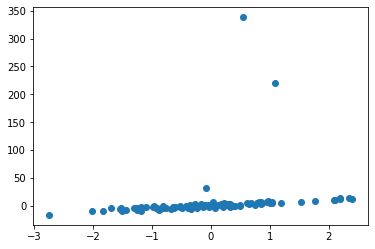

In [176]:
import random
from sklearn.datasets import make_regression
from matplotlib import pyplot
# generate regression dataset
x, y = make_regression(n_samples=100, n_features=1, noise=2)
y = [i if random.random() > 0.02 else i + random.random() *500 for i in y]
# plot regression dataset
pyplot.scatter(x,y)
pyplot.show()

In [177]:
N = len(x)
fit = robost_regression_ard.vb(
    data  = {'N': N, 'x': x[:, 0], 'y': y}
)
fit = pystan_vb_extract(fit)
alpha = fit['alpha'].mean(axis=0)
beta = fit['beta'].mean(axis=0)

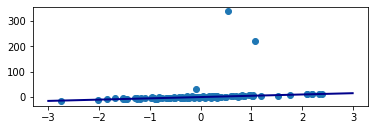

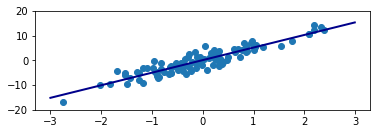

In [188]:

xrange = np.array([-3 + i * 6/1000 for i in range(1000)])
y_ = alpha * xrange + beta

plt.subplot(2, 1, 1)
plt.scatter(x,y)
plt.plot(np.array([-3 + i * 6/1000 for i in range(1000)]), y_, color='darkblue', linewidth=2)
plt.show()

plt.subplot(2, 1, 2)
plt.scatter(x,y)
plt.plot(np.array([-3 + i * 6/1000 for i in range(1000)]), y_, color='darkblue', linewidth=2)
plt.ylim(-20, 20)
plt.show()



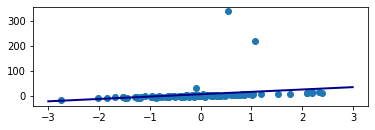

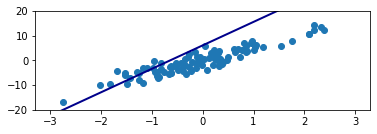

In [187]:
from sklearn.linear_model import LinearRegression
r = LinearRegression().fit(x, y=y)
y_ = r.predict(np.array([[-3 + i * 6/1000 for i in range(1000)],]).T)

plt.subplot(2, 1, 1)
plt.scatter(x,y)
plt.plot(np.array([-3 + i * 6/1000 for i in range(1000)]), y_, color='darkblue', linewidth=2)
plt.show()

plt.subplot(2, 1, 2)
plt.scatter(x,y)
plt.plot(np.array([-3 + i * 6/1000 for i in range(1000)]), y_, color='darkblue', linewidth=2)
plt.ylim(-20, 20)
plt.show()


### 2.8 PCA

In [232]:
import matplotlib.pyplot as plt
from sklearn import datasets

data = datasets.fetch_olivetti_faces()
images = data.images.reshape(400, -1)
labels = data.target

In [2]:
%%stan pca
data {
    int<lower=0> N; // Number of samples
    int<lower=0> D; // The original dimension
    int<lower=0> K; // The latent dimension
    matrix[N, D] X; // The data matrix
}

parameters {
    matrix[N, K] Z; // The latent matrix
    matrix[D, K] W; // The weight matrix
    real<lower=0> tau; // Noise term 
    vector<lower=0>[K] alpha; // ARD prior
}

transformed parameters{
    vector<lower=0>[K] t_alpha;
    real<lower=0> t_tau;
            t_alpha = inv(sqrt(alpha));
            t_tau = inv(sqrt(tau));
}

model {
    tau ~ gamma(1,1);
    to_vector(Z) ~ normal(0,1);
    alpha ~ gamma(1e-3,1e-3);
    for(k in 1:K) 
      W[,k] ~ normal(0, t_alpha[k]);
    to_vector(X) ~ normal(to_vector(Z*W'), t_tau);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL pca_993caf18aaeb0bf61622abd3e215f0a2 NOW.


Creating pystan model & assigning it to variable name "pca".
Stan options:
 {'model_name': 'pca', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "pca"!
Compilation took 54 seconds.


In [328]:
fit = pca.vb(
    data={'N': 400, 'D': 4096, 'K': 64, 'X': images}
)

In [329]:
from collections import OrderedDict
def pystan_vb_extract(results):
    param_specs = results['sampler_param_names']
    samples = results['sampler_params']
    n = len(samples[0])

    # first pass, calculate the shape
    param_shapes = OrderedDict()
    for param_spec in param_specs:
        splt = param_spec.split('[')
        name = splt[0]
        if len(splt) > 1:
            idxs = [int(i) for i in splt[1][:-1].split(',')]  # no +1 for shape calculation because pystan already returns 1-based indexes for vb!
        else:
            idxs = ()
        param_shapes[name] = np.maximum(idxs, param_shapes.get(name, idxs))

    # create arrays
    params = OrderedDict([(name, np.nan * np.empty((n, ) + tuple(shape))) for name, shape in param_shapes.items()])

    # second pass, set arrays
    for param_spec, param_samples in zip(param_specs, samples):
        splt = param_spec.split('[')
        name = splt[0]
        if len(splt) > 1:
            idxs = [int(i) - 1 for i in splt[1][:-1].split(',')]  # -1 because pystan returns 1-based indexes for vb!
        else:
            idxs = ()
        params[name][(..., ) + tuple(idxs)] = param_samples

    return params

In [330]:
res = pystan_vb_extract(fit)

In [331]:
W = res["W"].mean(axis=0)
Z = res["Z"].mean(axis=0)
reconstruct = np.dot(Z, W.T)

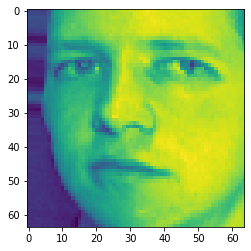

In [332]:
plt.imshow(images[3].reshape(64, 64))

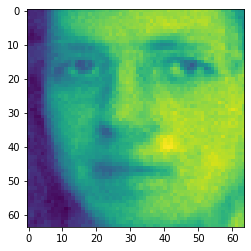

In [333]:
plt.imshow(reconstruct[3].reshape(64, 64))

In [357]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3)
clf = KNeighborsClassifier(n_neighbors=3, metric='l2').fit(X_train, y_train)
print(clf.score(X_train, y=y_train))
print(clf.score(X_test, y=y_test))

0.9678571428571429
0.8166666666666667


In [358]:
X_train, X_test, y_train, y_test = train_test_split(Z, labels, test_size=0.3)
clf = KNeighborsClassifier(n_neighbors=3, metric='l2').fit(X_train, y_train)

print(clf.score(X_train, y=y_train))
print(clf.score(X_test, y=y_test))

0.9535714285714286
0.8583333333333333
